## Apply Rank Bandit on the Jester Jokes Dataset
The goal is to maximize the number of clicks on any of the top 10 recommended jokes using `IndependentBandits`

In [1]:
url = 'https://jester-jokes-data.s3.amazonaws.com/jesterfinal151cols.csv'

In [2]:
import codecs
import csv
from urllib.request import urlopen

import numpy as np


def get_jester_data(url):
    data = []
    file_stream = urlopen(url)
    csv_reader = csv.reader(codecs.iterdecode(file_stream, 'utf-8'), delimiter=',')
    for row in csv_reader:
        data_row = []
        for _item in row[1:]:
            if _item in {'99', ''} or float(_item) < 7.0:  # Rates above or equal to 7 are considered positive i.e. 1. Oterhwise 0.0.
                data_row.append(0.0)
            else:
                data_row.append(1.0)
        data.append(data_row)

    return np.asarray(data)

In [3]:
jester_data = get_jester_data(url)

filtered_data = []
for _row in jester_data:
    if sum(_row) > 1:  # Keep only the rows where a user has rated at least one 1 joke
        filtered_data.append(_row.tolist())

data = np.asarray(filtered_data)

In [4]:
import random
from tqdm import tqdm

from mab_ranking.bandits.rank_bandits import IndependentBandits
from mab_ranking.bandits.bandits import BetaThompsonSampling


independent_bandits = IndependentBandits(
        num_arms=data.shape[1],
        num_ranks=10,  # Recommend the best 10 jokes
        bandit_class=BetaThompsonSampling
    )

num_steps = 7000
sum_binary = 0.0
ctr_list = []

for i in tqdm(range(1, num_steps + 1)):
    # Pick a user randomly
    random_user_idx = random.randint(0, data.shape[0] - 1)

    selected_items = independent_bandits.choose()
    ground_truth = np.argwhere(data[random_user_idx] == 1).flatten().tolist()

    hit_rate = len(set(ground_truth).intersection(set(selected_items))) / len(set(ground_truth))

    feedback_list = [1.0 if _item in ground_truth else 0.0 for _item in selected_items]
    independent_bandits.update(selected_items, feedback_list)

    binary_relevancy = 1.0 if hit_rate > 0 else 0.0
    sum_binary += binary_relevancy
    ctr_list.append(sum_binary / i)

100%|██████████| 7000/7000 [00:25<00:00, 273.41it/s]


In [5]:
import matplotlib.pyplot as plt


def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)

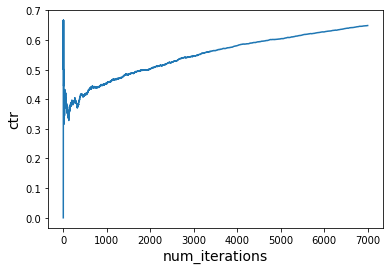

In [6]:
plot_ctr(len(ctr_list), ctr_list)